In [1]:
# MNIST test dataset
from tensorflow.keras.datasets import mnist

In [2]:
# import helper library
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import dataset
(trainx, trainy), (testx, testy) = mnist.load_data()

In [4]:
# seeing the shapes of imported dataset
trainx.shape, trainy.shape, testx.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

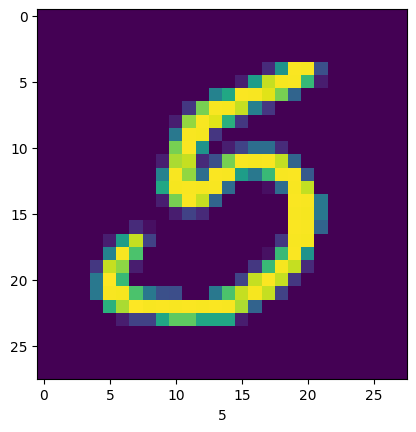

In [5]:
def choose_random_train():
    random_number = np.random.randint(0, 60000)
    sample_X = trainx[random_number]
    sample_y = trainy[random_number]
    return sample_X, sample_y, random_number

random_X, random_y, _ = choose_random_train()
plt.imshow(random_X)
plt.xlabel(random_y)

cursor = 0
def batch_generator_1000():
    global cursor
    print(cursor)
    x_batch = trainx[cursor:cursor+1000]
    y_batch = trainy[cursor:cursor+1000]
    cursor += 1000
    cursor %= 60000
    return x_batch, y_batch

# aax, aay = batch_generator_1000()
# aax.shape, aay.shape

### Making the layers

##### Layers
- Each layers maintains following associated datatypes:
    - Information types
        - name: Name of the layer
        - parameters_count: Number of parameters of the layer
    - Useful types
        - Depends on the type of layer:
            - Eg: For weights layer, it's the weight matrix
            - Eg: For bias layer, it's the bias vector
            - Eg: For the activation layer, it is nothing
        - They can be abstracted away for the user of the layer

- Each layer should have the following functions
    - Apply (input) -> output
        - It applies the layer's operation to it's input to give an output
    - Input gradient (output gradient, input value, output value) -> gradient values for input
        - It calculates the gradient for the input given the gradient values for the output.
        - It takes the output gradient values, it's input values and it's output values, if it saves the computations
    - Parameter gradient (output gradient, input value, output value) -> gradient values for parameters
        - It calculates the gradient for the parameters using the output gradients, input values and output values
        - If the layer doesn't have any parameters, it has to output zero (because we will sum the gradients, and we need something to sum it)
    - dummy gradient () -> a zero of shape of parameters
        - a zero gradient value of shape of the parameters
    - learn (parameter gradient, learning rate)
        - It modifies the parameter given the gradient of the parameters and the learning rate

In [6]:
# helper function
def expand_dims_and_transpose(x):
    return np.transpose(np.expand_dims(x, 0))
def expand_dims(x):
    return np.expand_dims(x, 0)

# layers
class Flattener:
    def __init__(self, shape):
        self.name = f"Flattener                 : {shape} to {np.prod(shape)}\n"
        self.param_count = 0

        self.from_shape = shape
    
    def apply(self, input_value):
        return np.ndarray.flatten(input_value)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return np.ndarray.reshape(output_gradient, self.from_shape)
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Scaler:
    def __init__(self, scale_factor):
        self.name = f"Scaler with scale factor {scale_factor}"
        self.param_count = 0

        self.scale_factor = scale_factor
    
    def apply(self, input_value):
        return self.scale_factor * input_value
    
    def input_gradient(self, output_gradient, input_value=None, output_value = None):
        return self.scale_factor * output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Weights:
    def __init__(self, input_size, output_size):
        self.name = f"Weights layer             : {input_size} to {output_size}"
        self.param_count = input_size * output_size
        
        # We create a transposed weights because input is a row vector
        self.weights = np.random.rand(input_size, output_size) - .5

    def apply(self, input_value):
        return np.matmul(input_value, self.weights)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        transposed_output_gradient = expand_dims_and_transpose(output_gradient)
        return np.transpose(np.matmul(self.weights, transposed_output_gradient))[0,:]
    
    def parameter_gradient(self, output_gradient, input_value, output_value=None):
        transposed_input = expand_dims_and_transpose(input_value)
        # print(np.shape(transposed_input), np.shape(output_gradient))
        return np.matmul(transposed_input, expand_dims(output_gradient))
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.weights))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.weights -= learning_rate * parameter_gradient_value

class Biases:
    def __init__(self, input_size):
        self.name = f"Biases layer              : {input_size}"
        self.param_count = input_size

        # We create a row vector of biases because input is a row vector
        self.biases = np.random.rand(input_size) - .5
    
    def apply(self, input_value):
        return input_value + self.biases
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.biases))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.biases -= learning_rate * parameter_gradient_value

class ReluActivation:
    def __init__(self):
        self.name = f"ReLU Activation\n"
        self.param_count = 0

        # we create a vectorized function for activaton
        self.activation_function = np.vectorize(lambda x: 0 if x < 0 else x)
        # similarly we create a vectorized function for gradient
        self.gradient_function = np.vectorize(lambda x: 0 if x < 0 else 1)
    
    def apply(self, input_value):
        return self.activation_function(input_value)
    
    def input_gradient(self, output_gradient, input_value, output_value=None):
        return np.multiply(output_gradient, self.gradient_function(input_value))
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class SoftmaxActivationOnlyWhenNeeded:
    def __init__(self, need=False):
        self.name = f"Softmax Activation, Activated:{need}\n"
        self.param_count = 0
        self.need = need
    
    def actual_apply(self, input_value):
        maximum = np.max(input_value)
        new_data = np.exp(input_value-maximum)
        denominator = np.sum(new_data)
        return new_data/denominator
        
    
    def apply(self, input_value):
        if self.need:
            return self.actual_apply(input_value)
        return input_value
    
    def actual_input_gradient(self, output_gradient, input_value, output_value=None):
        size = len(output_value)
        if output_value == None:
            output_value = self.actual_apply(input_value)
        magic_matrix = np.diag(output_value) - np.matmul(np.transpose(output_value), output_value)
        return np.matmul(output_gradient, magic_matrix)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        if self.need:
            return self.actual_input_gradient(output_gradient, input_value, output_value)
        return output_gradient
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

In [7]:
# dataset transformation
class OneHotEncoder:
    def __init__(self, input_size):
        self.name = "One hot encoder of size : {input_size}"
        self.size = input_size
    
    def __call__(self, number):
        output = np.zeros(self.size)
        output[number] = 1
        return output

class Identity:
    def __init__(self):
        self.name = "None"
    def __call__(self, x):
        return x

### Making the Loss Function
##### Loss function
- Each loss function has following data types
    - Name: Name of the loss function.

- Each loss function should implement the following methods
    - Apply(prediction, ground_truth) -> loss value
        - It calculates the required loss function.
    - Call(prediction, gournd_truth) -> loss value
        - It calls the apply function under the hood.
    - Prediction gradient(prediction, ground_truth) -> gradient values for output
        - It returns the gradient value for the loss wrt prediction value.
        - To calculate it, it is supplied with the prediction value and the ground truth.

In [8]:
def softmax_function(input_value):
    maximum = np.max(input_value)
    new_data = np.exp(input_value-maximum)
    denominator = np.sum(new_data)
    return new_data/denominator

class CrossEntropyLossFunctionFromLogits:
    def __init__(self):
        self.name = "Cross Entropy Loss Function from the logits"
        self.loss_function = softmax_function
    
    def apply(self, prediction, ground_truth):
        # ground_truth_class = np.argmax(ground_truth)
        # return -np.log(softmax_function(prediction)[ground_truth_class])

        softmax_output = softmax_function(prediction)
        return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))
    
    def __call__(self, prediction, ground_truth):
        return self.apply(prediction, ground_truth)
    
    def prediction_gradient(self, prediction, ground_truth):
        return np.sum(ground_truth)*softmax_function(prediction) - ground_truth


### Making the model
##### Sequential model
- Each sequential model should have following data types
    - Information types
        - Name: Name of the model
    - Useful types
        - Layers: A list of the sequential layers
        - Loss function : The function that defines the loss
        - Dataset transformation : The transformation that is applied to the output of the dataset

        - Cumulative parameter gradients for all layers
        - 
- Each sequential model should implement the following methods
    - Informational / debug
        - representation
    - Useful
        - inference (input) -> output
            - For simple inference
        - Reset gradient
            - To reset the parameter gradients for all layers
        - forward propagation (input) -> output
            - For simple layer by layer forward propagation
            - Saves the input to each layer
            - Saves the last output
            - Prepares for the back propagation
        - Back propagation (output gradients) ->
            - Layer by layer back propagation calculating the parameter gradients at each step, and back-propagating the intermediate gradients
            - Sums the parameter gradients
        - input gradients
            - To calculate the gradient of the input given the gradient of the output

    

In [9]:
class Sequential_Model:
    def __init__(self, layers, loss_function, name="Sequential Model",  dataset_transformation=Identity()):
        self.name = name

        self.layers = layers
        self.loss_function = loss_function
        self.dataset_transformation = dataset_transformation
        self.param_count = sum(layer.param_count for layer in layers)
        self.last_loss = 0
    
    def inference(self, input_value):
        last_output = input_value
        for layer in self.layers:
            last_output = layer.apply(last_output)
        return last_output

    def __call__(self, input_value):
        return self.inference(input_value)

    def reset_gradient(self):
        self.parameter_gradients = [layer.dummy_gradient() for layer in self.layers]
        self.last_loss = 0
    
    def forward_propagation(self, input_value):
        self.last_inputs = []

        last_input = input_value
        self.last_inputs.append(last_input)
        for layer in self.layers:
            last_input = layer.apply(last_input)
            self.last_inputs.append(last_input)
        return last_input
    
    def back_propagation(self, output_gradient):
        last_gradient = output_gradient
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            input_value = self.last_inputs[i]
            output_value = self.last_inputs[i+1]
            parameter_gradient = layer.parameter_gradient(last_gradient, input_value, output_value)

            # save cumulative gradients
            self.parameter_gradients[i] += parameter_gradient

            last_gradient = layer.input_gradient(last_gradient, input_value, output_value)
        return last_gradient
    
    def input_gradients(self, output_gradient):
        last = len(self.layers()) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            output_gradient = layer.input_gradient(output_gradient, self.last_inputs[i], self.last_inputs[i+1])
        return output_gradient
    
    def see_dataset_for_training(self, input_dataset, output_dataset):
        ground_truth = self.dataset_transformation(output_dataset)
        prediction = self.forward_propagation(input_dataset)
        prediction_gradient = self.loss_function.prediction_gradient(prediction, ground_truth)
        last_gradient = self.back_propagation(prediction_gradient)
        self.last_loss += self.loss_function(prediction, ground_truth)
        return last_gradient

    def make_model_learn(self, learning_rate):
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            layer.learn(self.parameter_gradients[i], learning_rate)
        pass

    def get_loss(self):
        return self.last_loss
    
    def __repr__(self):
        representation = f"{self.name}\n\n" 
        i = 0
        for layer in self.layers:
            i += 1
            representation += f"{i}. {layer.name}\n"
        representation += f"Total parameters = {self.param_count}\n"
        representation += f"Loss function = {self.loss_function.name}\n"
        return representation
        

        
            

In [10]:
# Building the model

MnistClassificationModel = Sequential_Model([
        Scaler(scale_factor=(1/255)),
        Flattener(shape=(28,28)),
    
        Weights(28*28, 256),
        Biases(256),
        ReluActivation(),
    
        Weights(256, 64),
        Biases(64),
        ReluActivation(),
    
        Weights(64, 10),
        Biases(10),
    
        SoftmaxActivationOnlyWhenNeeded(),
    ],
    loss_function=CrossEntropyLossFunctionFromLogits(),
    name="Simple MNIST handwritten digit dataset classifier",
    dataset_transformation=OneHotEncoder(10)
)
# Reset cursor for training dataset if model is reinstiated
cursor = 0
losses = []
# also reset the loss, because when model is reinstated training is gone, and so are losses

print(MnistClassificationModel)
# output = MnistClassificationModel(random_X)
# print(output)
# print(softmax_function(output))


Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 256
4. Biases layer              : 256
5. ReLU Activation

6. Weights layer             : 256 to 64
7. Biases layer              : 64
8. ReLU Activation

9. Weights layer             : 64 to 10
10. Biases layer              : 10
11. Softmax Activation, Activated:False

Total parameters = 218058
Loss function = Cross Entropy Loss Function from the logits



Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 256
4. Biases layer              : 256
5. ReLU Activation

6. Weights layer             : 256 to 64
7. Biases layer              : 64
8. ReLU Activation

9. Weights layer             : 64 to 10
10. Biases layer              : 10
11. Softmax Activation, Activated:False

Total parameters = 218058
Loss function = Cross Entropy Loss Function from the logits



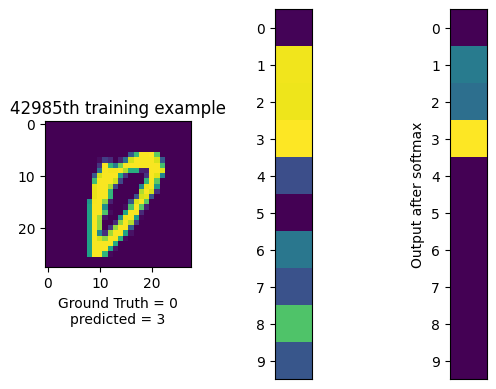

Logits output =  [-16.33067507  20.6331796   20.50963545  21.51413426  -7.62002986
 -16.77175758  -1.57427301  -7.15626345  11.02692244  -6.52839125]
Softmax output =  [2.05888099e-17 2.32717670e-01 2.05671831e-01 5.61594836e-01
 1.24915518e-13 1.32455972e-17 5.27539800e-11 1.98622109e-13
 1.56633583e-05 3.72142284e-13]
Loss value for this example =  0.0


In [11]:
def model_tester(print_outputs=False):
    rx, ry, n = choose_random_train()
    prediction = (MnistClassificationModel(rx))

    plt.subplot(1,3,1)
    plt.imshow(rx)
    plt.xlabel(f"Ground Truth = {ry}\npredicted = {np.argmax(prediction)}")
    plt.title(f"{n}th training example")

    plt.subplot(1,3,2)
    plt.imshow(np.reshape(prediction, (-1,1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(np.reshape(softmax_function(prediction), (-1, 1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    plt.ylabel("Output after softmax")

    plt.show()
    if print_outputs:
        print("Logits output = ", prediction)
        print("Softmax output = ", softmax_function(prediction))
        print("Loss value for this example = ", MnistClassificationModel.loss_function(prediction, ry))

print(MnistClassificationModel)
model_tester(True)


======= Epoch : 1 =======
Initial Loss = 0
0
Loss after training = 30291.780691545544


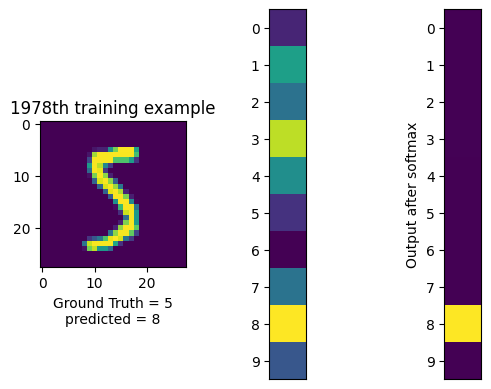

Logits output =  [-12.05063925  11.61988608   1.87534521  28.66006103   7.84762071
  -9.77089809 -17.3473367    2.23141321  33.80322176  -3.48007166]
Softmax output =  [1.21169308e-20 2.30871945e-10 1.35322756e-14 5.80530600e-03
 5.31003189e-12 1.18432701e-19 6.06828756e-23 1.93200926e-14
 9.94194694e-01 6.39061770e-17]
Loss value for this example =  -73970.16123084337

======= Epoch : 2 =======
Initial Loss = 30291.780691545544
1000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_61997/2148852362.py:17: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))


Loss after training = 28467.92194598704


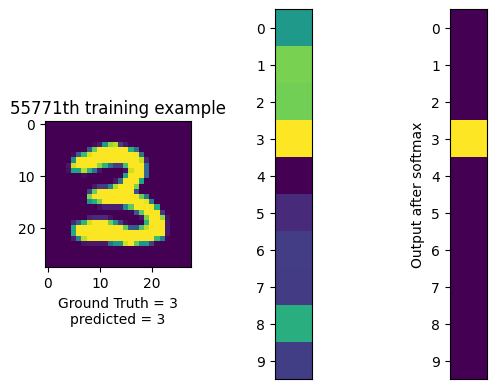

Logits output =  [  7.54526811  21.91379536  21.14981391  33.04316919 -22.4701059
 -15.85709548 -12.32843056 -12.8248538   12.64100231 -12.2218653 ]
Softmax output =  [8.44098096e-12 1.46745576e-05 6.83552835e-06 9.99978489e-01
 7.77824490e-25 5.79262678e-22 1.97403683e-20 1.20160403e-20
 1.37861235e-09 2.19601830e-20]
Loss value for this example =  -78389.82591777766

======= Epoch : 3 =======
Initial Loss = 28467.92194598704
2000
Loss after training = 24156.84871361981


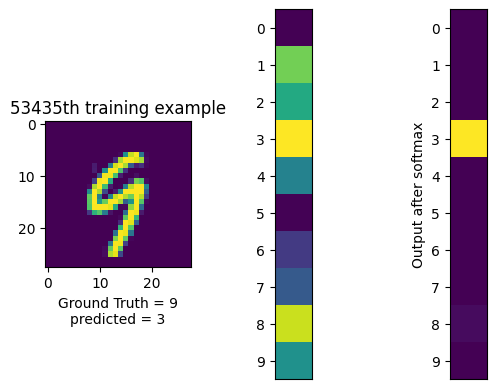

Logits output =  [-16.29504968  17.80633575   9.97615982  27.01840961   2.9668268
 -16.09349108  -9.01643436  -3.99429031  23.4854754    5.53867512]
Softmax output =  [1.50194380e-19 9.69833544e-05 3.85562689e-08 9.71516192e-01
 3.48321553e-11 1.83733974e-19 2.17628692e-16 3.30221692e-14
 2.83867851e-02 4.55952795e-10]
Loss value for this example =  -56582.871757331886

======= Epoch : 4 =======
Initial Loss = 24156.84871361981
3000
Loss after training = 20204.97091926927


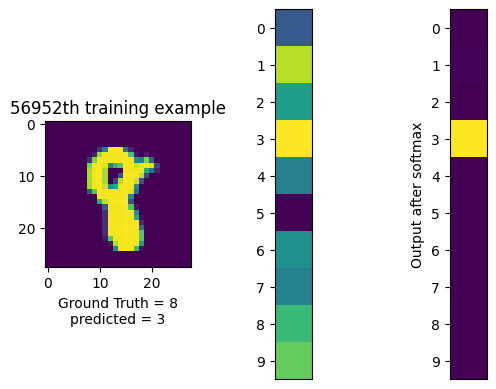

Logits output =  [ -7.25365559  20.20849155   4.94834755  24.81109447  -0.48297912
 -20.01301907   2.62785277  -0.05343238  10.35923594  14.29953662]
Softmax output =  [1.17519958e-14 9.92591591e-03 2.34085362e-09 9.90046608e-01
 1.02465828e-11 3.37901777e-20 2.29930286e-10 1.57444987e-11
 5.23954081e-07 2.69490878e-05]
Loss value for this example =  -49292.35712245925

======= Epoch : 5 =======
Initial Loss = 20204.97091926927
4000
Loss after training = 19561.703659234


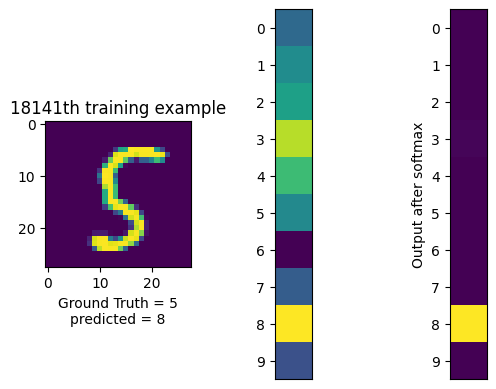

Logits output =  [ -5.58071247   0.38537      3.8836841   17.18772386   8.73220879
  -0.19381985 -19.57664893  -7.37029107  21.60411362  -9.30205146]
Softmax output =  [1.54370761e-12 6.02007273e-10 1.99021616e-08 1.19335952e-02
 2.53856196e-06 3.37336071e-10 1.28886393e-18 2.57846316e-13
 9.88063845e-01 3.73601021e-14]
Loss value for this example =  -51804.30145947566

======= Epoch : 6 =======
Initial Loss = 19561.703659234
5000
Loss after training = 16835.048110108946

======= Epoch : 7 =======
Initial Loss = 16835.048110108946
6000
Loss after training = 16556.97963945403


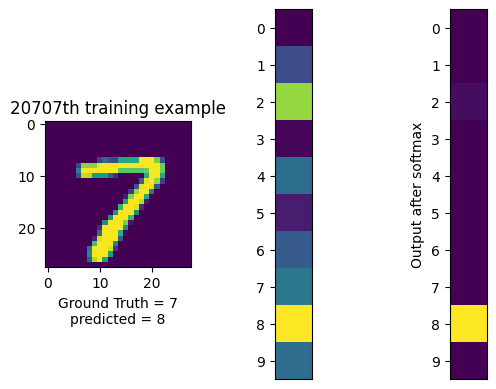

Logits output =  [-9.96508974 -5.09845291  7.84161545 -9.60667717 -2.30733014 -8.36912151
 -3.88201136 -1.59684907 11.23110011 -2.42266399]
Softmax output =  [6.02842580e-10 7.82992213e-08 3.26255414e-02 8.62701436e-10
 1.27622327e-06 2.97388464e-09 2.64272086e-07 2.59707606e-06
 9.67369101e-01 1.13720249e-06]
Loss value for this example =  -34067.740029803506

======= Epoch : 8 =======
Initial Loss = 16556.97963945403
7000
Loss after training = 14377.876807123357

======= Epoch : 9 =======
Initial Loss = 14377.876807123357
8000
Loss after training = 14082.480579481151

======= Epoch : 10 =======
Initial Loss = 14082.480579481151
9000
Loss after training = 13180.778239081068


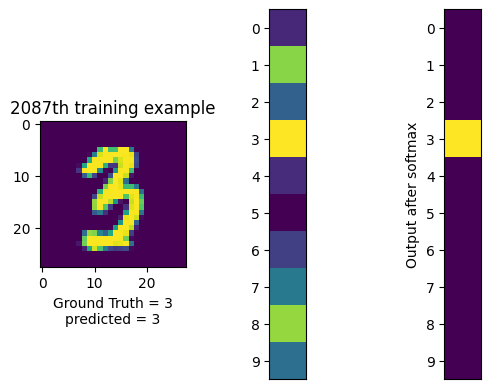

Logits output =  [-2.40861261 23.59604967  4.92721806 30.06472345 -1.8465882  -6.45247078
  0.47281072  8.27818873 24.24027016  6.82165941]
Softmax output =  [7.85338583e-15 1.54432345e-03 1.20494636e-11 9.95514509e-01
 1.37765678e-14 1.37667569e-16 1.40101630e-13 3.43776182e-10
 2.94116691e-03 8.01148716e-11]
Loss value for this example =  -53888.73225001161

======= Epoch : 11 =======
Initial Loss = 13180.778239081068
10000
Loss after training = 12499.852101667953

======= Epoch : 12 =======
Initial Loss = 12499.852101667953
11000
Loss after training = 11934.760436259972

======= Epoch : 13 =======
Initial Loss = 11934.760436259972
12000
Loss after training = 11611.040988775807

======= Epoch : 14 =======
Initial Loss = 11611.040988775807
13000
Loss after training = 10400.850212394194


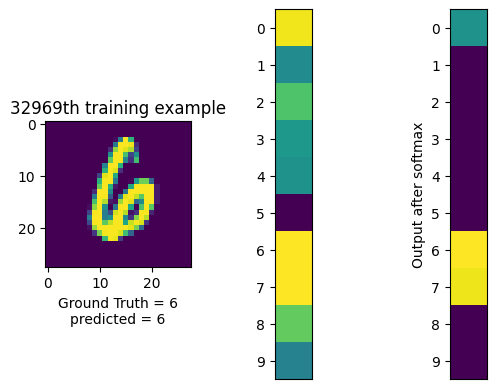

Logits output =  [  9.15952523  -6.66780416   1.09290095  -4.96698306  -5.71572775
 -21.9281982    9.82376895   9.79877412   2.16334466  -7.90996702]
Softmax output =  [2.06641118e-01 2.76372562e-08 6.48524417e-05 1.51409158e-07
 7.16104592e-08 6.51613392e-15 4.01507929e-01 3.91596688e-01
 1.89153388e-04 7.98050639e-09]
Loss value for this example =  -30628.333941984758

======= Epoch : 15 =======
Initial Loss = 10400.850212394194
14000
Loss after training = 10499.476018042102

======= Epoch : 16 =======
Initial Loss = 10499.476018042102
15000
Loss after training = 9434.007751584051

======= Epoch : 17 =======
Initial Loss = 9434.007751584051
16000
Loss after training = 9190.55753034328

======= Epoch : 18 =======
Initial Loss = 9190.55753034328
17000
Loss after training = 8988.535308930106

======= Epoch : 19 =======
Initial Loss = 8988.535308930106
18000
Loss after training = 8527.493202286632

======= Epoch : 20 =======
Initial Loss = 8527.493202286632
19000
Loss after training = 88

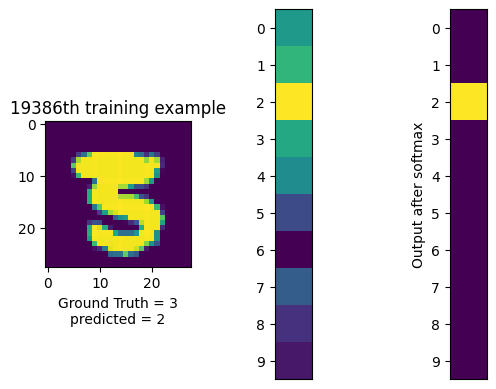

Logits output =  [  9.54299152  14.01431533  26.86393031  11.98407487   7.51304436
  -2.01908984 -10.71074613   0.2978539   -5.33539069  -8.34882793]
Softmax output =  [3.00338189e-08 2.62713151e-06 9.99996994e-01 3.44952731e-07
 3.94471569e-09 2.85931776e-13 4.80312684e-17 2.90066987e-12
 1.03755532e-14 5.09673554e-16]
Loss value for this example =  -56883.80589699034

======= Epoch : 21 =======
Initial Loss = 8824.323403024102
20000
Loss after training = 8069.412997982392

======= Epoch : 22 =======
Initial Loss = 8069.412997982392
21000
Loss after training = 7593.597837273398

======= Epoch : 23 =======
Initial Loss = 7593.597837273398
22000
Loss after training = 8528.849133059597

======= Epoch : 24 =======
Initial Loss = 8528.849133059597
23000
Loss after training = 8078.030895898761

======= Epoch : 25 =======
Initial Loss = 8078.030895898761
24000
Loss after training = 7948.819549217577

======= Epoch : 26 =======
Initial Loss = 7948.819549217577
25000
Loss after training = 7388

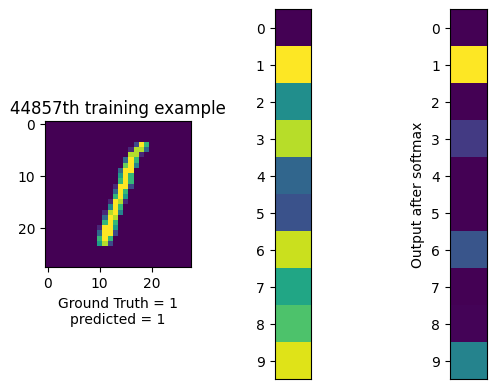

Logits output =  [-8.76490144  7.64991531 -0.67597284  5.88369568 -3.36172801 -4.63891939
  6.31568058  0.97216576  3.08152756  6.84872628]
Softmax output =  [3.92210945e-08 5.27696295e-01 1.27789969e-04 9.02245248e-02
 8.71140314e-06 2.42890733e-06 1.38973905e-01 6.64162364e-04
 5.47467640e-03 2.36827467e-01]
Loss value for this example =  -17743.23334401944

======= Epoch : 29 =======
Initial Loss = 7178.756231391312
28000
Loss after training = 7397.21510145799

======= Epoch : 30 =======
Initial Loss = 7397.21510145799
29000
Loss after training = 7198.259977966566

======= Epoch : 31 =======
Initial Loss = 7198.259977966566
30000
Loss after training = 6956.495243477068

======= Epoch : 32 =======
Initial Loss = 6956.495243477068
31000
Loss after training = 7404.9369216463265

======= Epoch : 33 =======
Initial Loss = 7404.9369216463265
32000
Loss after training = 6598.272059236229

======= Epoch : 34 =======
Initial Loss = 6598.272059236229
33000
Loss after training = 6416.021044900

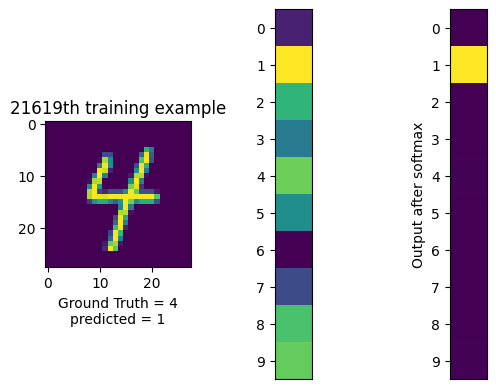

Logits output =  [ -9.21362119  11.52415335   3.60442975  -1.91140042   6.523535
   0.10321718 -11.2670923   -5.93479989   5.02130836   6.12563998]
Softmax output =  [9.72820759e-10 9.87038013e-01 3.58791066e-04 1.44326812e-06
 6.64649870e-03 1.08214218e-05 1.24802033e-10 2.58230078e-08
 1.47973580e-03 4.46466948e-03]
Loss value for this example =  -27920.750991933037


In [12]:
examples = 10
epochs = 40
last_epoch = -1
learning_rate = 0.003
for epoch in range(epochs):
    print(f"\n======= Epoch : {epoch+1} =======")
    print(f"Initial Loss = {MnistClassificationModel.get_loss()}")
    MnistClassificationModel.reset_gradient()
    batchx, batchy = batch_generator_1000()
    for tx, ty in zip(batchx, batchy):
        MnistClassificationModel.see_dataset_for_training(tx, ty)
        
    MnistClassificationModel.make_model_learn(learning_rate/1000)
    print(f"Loss after training = {MnistClassificationModel.get_loss()}")
    losses.append(MnistClassificationModel.get_loss())

    log_epoch = np.floor(np.log(epoch + 1)/np.log(epochs)*examples)
    if log_epoch != last_epoch:
        model_tester(print_outputs=True)
    last_epoch = log_epoch


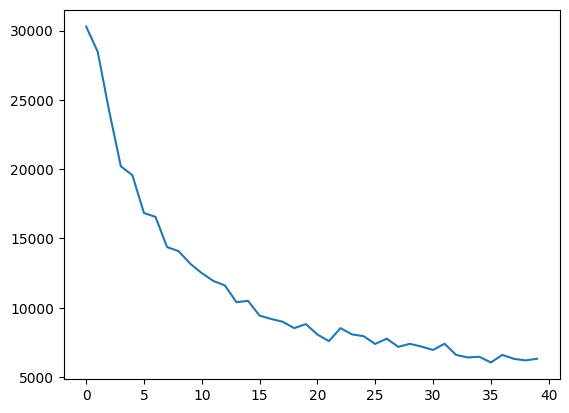

In [16]:
plt.plot(losses)
plt.savefig("Loss-graph.png")

array([[-9.22870364],
       [12.12411442],
       [ 3.84715178],
       [ 2.39653091],
       [-4.95485918],
       [-4.15091983],
       [ 9.63948275],
       [ 4.07246093],
       [ 5.1948062 ],
       [ 4.4539429 ]])

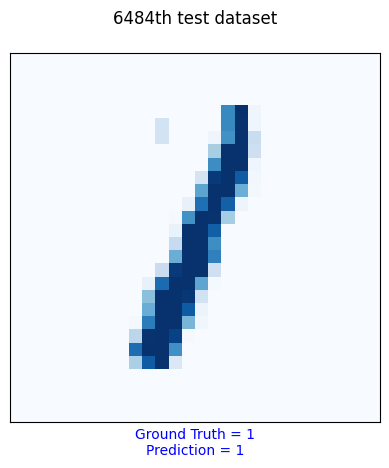

In [14]:
def choose_random_test():
    limit = len(testy)
    random_number = np.random.randint(0, limit)
    sample_X = testx[random_number]
    sample_y = testy[random_number]
    return sample_X, sample_y, random_number
    
def choose_random_and_test_model(log_output=True):
    xx, yy, n = choose_random_test()
    prediction = MnistClassificationModel(xx)
    prediction_number = np.argmax(prediction)

    correct = prediction_number == yy
    colour = 'blue' if correct else 'red'
    plt.imshow(xx, cmap="Blues")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Ground Truth = {yy}\nPrediction = {prediction_number}", color=colour)
    plt.title(f"{n}th test dataset\n")
    return np.reshape(prediction, (-1,1))
    
choose_random_and_test_model() 

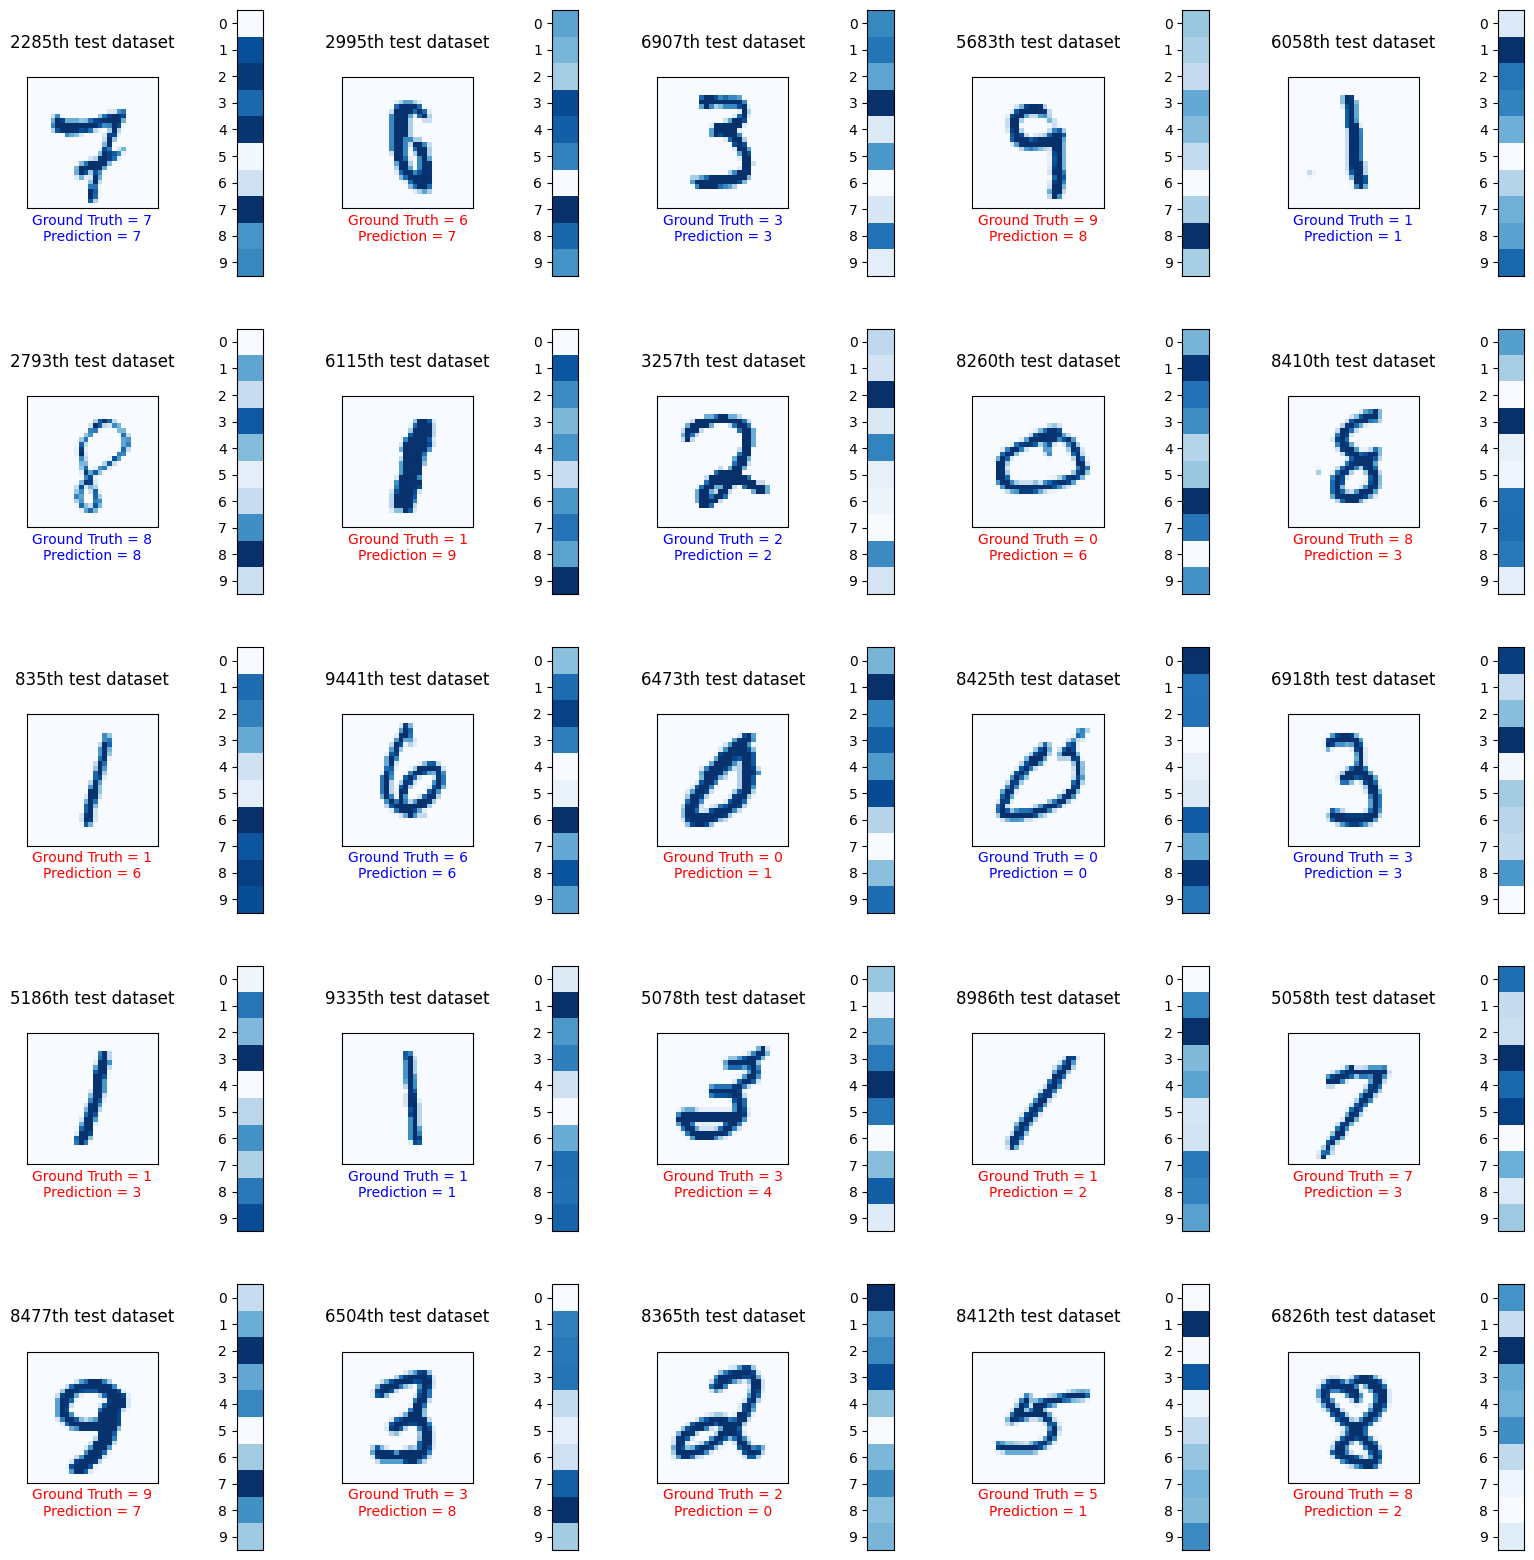

In [15]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,10, i*2+1)
    prediction = choose_random_and_test_model()

    plt.subplot(5, 10, i*2+2)
    plt.imshow(prediction, cmap='Blues')
    plt.yticks(np.arange(10))
    plt.xticks([])

plt.savefig("Output.png")
    